In [1]:
# ==== DBSCAN clustering: config and utilities (enhanced, refactored, now pure unsupervised) ====

RANDOM_STATE = 42
IMAGE_EMBEDDING_CSV_PATH = "eff_embeddings.csv"  # Image embedding CSV path if available
SENTENCEBERT_EMBEDDING_PATH = "./TF_IDF+SBERT/sentencebert_embeddings.npy"  # Optional SentenceBERT embeddings .npy
STRICT_FIT_ON_TRAIN_ITEMS = True
USE_TEXT = True
USE_NUMERIC = True
USE_IMAGE = True
USE_SENTENCEBERT = True  # Toggle for SentenceBERT integration
VARIANCE_THRESHOLD = 0.01  # Low variance feature removal threshold
CLUSTER_DISTANCE_METRIC = 'cosine'  # Use cosine distance for high-dimensional normalized features

# Auto-select bucket column if available (prefer category, else brand)
_PREFFERED_BUCKETS_ORDER = ["category_encoded", "brand_encoded"]
_available_cols = []
try:
    if 'df' in globals():
        _available_cols = list(getattr(df, 'columns', []))
except Exception:
    _available_cols = []
for _col in _PREFFERED_BUCKETS_ORDER:
    if _col in _available_cols:
        BUCKET_BY = _col
        break
else:
    BUCKET_BY = None

DBSCAN_MIN_SAMPLES = 5
DBSCAN_EPS = None  # Will be suggested then searched

import os
import warnings
import numpy as np
import pandas as pd
from typing import Tuple, Dict, List, Optional
from IPython.display import display
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import precision_recall_fscore_support, silhouette_score, calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
import psutil

# Optional memory_profiler support
try:
    from memory_profiler import memory_usage as _mem_usage
    HAS_MEMPROF = True
except Exception:
    HAS_MEMPROF = False

try:
    from tqdm.notebook import tqdm
    HAS_TQDM = True
except Exception:
    HAS_TQDM = False

# Memory usage monitor (prefers memory_profiler if available)

def memory_usage_mb() -> float:
    try:
        if HAS_MEMPROF:
            # current process usage in MB
            mem = _mem_usage(-1, interval=0.1, timeout=1)
            return float(mem[0]) if mem else float('nan')
        process = psutil.Process(os.getpid())
        return process.memory_info().rss / 1024 / 1024
    except Exception:
        return float('nan')

COMBINE_FN = None
try:
    COMBINE_FN = load_and_combine_features
except NameError:
    COMBINE_FN = None

# --- Feature configuration object to simplify parameter passing ---
from dataclasses import dataclass

@dataclass
class FeatureConfig:
    use_image_embeddings: bool = USE_IMAGE
    use_text_embeddings: bool = USE_TEXT
    use_numeric_features: bool = USE_NUMERIC
    use_sentencebert: bool = USE_SENTENCEBERT
    image_embedding_csv_path: Optional[str] = IMAGE_EMBEDDING_CSV_PATH
    sentencebert_path: Optional[str] = SENTENCEBERT_EMBEDDING_PATH
    variance_threshold: float = VARIANCE_THRESHOLD
    pca_variance_target: float = 0.95
    pca_min_components: int = 2
    incremental_pca_dim_threshold: int = 1500
    incremental_batch_size: int = 256
    random_state: int = RANDOM_STATE

# --- Feature combiner (pure unsupervised: excludes all label/target columns) ---

def safe_combine_features(
    df_items: pd.DataFrame,
    use_image_embeddings: bool = True,
    use_text_embeddings: bool = True,
    use_numeric_features: bool = True,
    use_sentencebert: bool = True,
    image_embedding_csv_path: Optional[str] = IMAGE_EMBEDDING_CSV_PATH,
    sentencebert_path: Optional[str] = SENTENCEBERT_EMBEDDING_PATH,
    variance_threshold: float = VARIANCE_THRESHOLD,
) -> np.ndarray:
    """Combine features with robust preprocessing (UNSUPERVISED ONLY).
    This function intentionally excludes any label / target related columns to avoid leakage.
    Steps:
      - Numeric: median imputation + per-part StandardScaler (excluding known label columns)
      - Text embedding col: stacked + per-part StandardScaler
      - SentenceBERT: load .npy + per-part StandardScaler
      - Image embeddings CSV: align if possible + per-part StandardScaler
      - After concatenation: VarianceThreshold to drop near-constant dims
    Excluded columns list includes common label identifiers.
    """
    print("[combine] Start combining features (pure unsupervised)...")
    parts: List[np.ndarray] = []

    if use_numeric_features:
        numeric_cols = df_items.select_dtypes(include=[np.number]).columns.tolist()
        # Extended exclusion to ensure no supervised signal leaks
        exclude_cols = [
            "label", "target", "y", "cluster", "is_train",
            "label_group", "group_id", "true_category", "category_id",
            "class", "ground_truth", "gt_label"
        ]
        numeric_cols = [c for c in numeric_cols if c not in exclude_cols]
        if numeric_cols:
            print(f"[combine] Numeric features ({len(numeric_cols)}) -> median impute + scale")
            numeric_data = df_items[numeric_cols]
            imputer = SimpleImputer(strategy='median')
            imputed = imputer.fit_transform(numeric_data).astype(np.float32)
            parts.append(StandardScaler().fit_transform(imputed).astype(np.float32))
        else:
            warnings.warn("[combine] No numeric columns found after exclusion.")

    if use_text_embeddings and 'text_embedding' in df_items.columns:
        try:
            text_series = df_items['text_embedding']
            first_non_null = next((v for v in text_series if v is not None), None)
            if first_non_null is not None:
                arrs = []
                for v in text_series:
                    if isinstance(v, (list, tuple, np.ndarray)):
                        arrs.append(np.asarray(v, dtype=np.float32))
                    else:
                        raise TypeError("text_embedding entries must be list/array")
                text_features = np.vstack(arrs)
                parts.append(StandardScaler().fit_transform(text_features).astype(np.float32))
                print(f"[combine] Added text_embedding shape {text_features.shape}")
            else:
                warnings.warn("[combine] text_embedding present but empty; skipped")
        except Exception as e:
            warnings.warn(f"[combine] Failed text_embedding processing: {e}")

    if use_sentencebert and sentencebert_path and os.path.exists(sentencebert_path):
        try:
            sbert_embeddings = np.load(sentencebert_path)
            if len(sbert_embeddings) == len(df_items):
                parts.append(StandardScaler().fit_transform(sbert_embeddings).astype(np.float32))
                print(f"[combine] Added SentenceBERT embeddings shape {sbert_embeddings.shape}")
            else:
                warnings.warn("[combine] SentenceBERT row count mismatch; skipped")
        except Exception as e:
            warnings.warn(f"[combine] Failed loading SentenceBERT embeddings: {e}")
    else:
        if use_sentencebert:
            print("[combine] SentenceBERT path missing or file not found; skipped")

    if use_image_embeddings and image_embedding_csv_path and isinstance(image_embedding_csv_path, str):
        if os.path.exists(image_embedding_csv_path):
            try:
                emb_df = pd.read_csv(image_embedding_csv_path)
                key_cols = [c for c in ("item_id", "id", "index", "posting_id") if c in emb_df.columns and c in df_items.columns]
                if key_cols:
                    key = key_cols[0]
                    emb_num = emb_df.drop(columns=[key]).select_dtypes(include=[np.number])
                    aligned = df_items[[key]].join(emb_num.set_index(emb_df[key]), on=key)
                    part = aligned.select_dtypes(include=[np.number]).to_numpy(dtype=np.float32)
                else:
                    emb_num = emb_df.select_dtypes(include=[np.number])
                    if len(emb_num) == len(df_items):
                        part = emb_num.to_numpy(dtype=np.float32)
                    else:
                        warnings.warn("[combine] Image embeddings row count mismatch; skipped.")
                        part = None
                if part is not None:
                    parts.append(StandardScaler().fit_transform(part).astype(np.float32))
                    print("[combine] Added image embeddings")
            except Exception as e:
                warnings.warn(f"[combine] Failed image embedding CSV: {e}")
        else:
            print(f"[combine] Image embedding CSV not found at {image_embedding_csv_path}; skipped")

    if not parts:
        raise ValueError("No features collected in safe_combine_features")

    out = np.concatenate(parts, axis=1)
    print(f"[combine] Concatenated raw shape: {out.shape}")

    try:
        selector = VarianceThreshold(threshold=variance_threshold)
        out = selector.fit_transform(out)
        print(f"[combine] After variance filtering (threshold={variance_threshold}): {out.shape}")
    except Exception as e:
        warnings.warn(f"[combine] VarianceThreshold failed: {e}")

    return out

if COMBINE_FN is None:
    COMBINE_FN = safe_combine_features
    print("Using safe_combine_features as COMBINE_FN (unsupervised, label columns excluded).")

# Internal evaluation metrics (pure unsupervised)

def internal_evaluation(X: np.ndarray, labels: np.ndarray) -> Dict[str, Optional[float]]:
    """Compute internal clustering metrics excluding noise (-1)."""
    unique_effective = np.unique(labels[labels != -1])
    if len(unique_effective) < 2:
        return {"silhouette": None, "calinski_harabasz": None}
    mask = labels != -1
    if mask.sum() < 3:
        return {"silhouette": None, "calinski_harabasz": None}
    try:
        sil = silhouette_score(X[mask], labels[mask])
    except ValueError as ve:
        warnings.warn(f"[metrics] Silhouette error: {ve}")
        sil = None
    except Exception as e:
        warnings.warn(f"[metrics] Silhouette unexpected error: {e}")
        sil = None
    try:
        ch = calinski_harabasz_score(X[mask], labels[mask])
    except ValueError as ve:
        warnings.warn(f"[metrics] Calinski-Harabasz error: {ve}")
        ch = None
    except Exception as e:
        warnings.warn(f"[metrics] Calinski-Harabasz unexpected error: {e}")
        ch = None
    return {"silhouette": sil, "calinski_harabasz": ch}

# Comprehensive evaluation (purely internal + Davies-Bouldin; no external labels)

def comprehensive_evaluation(X: np.ndarray, labels: np.ndarray) -> Dict[str, Optional[float]]:
    """Return internal metrics (silhouette, calinski_harabasz, davies_bouldin) without any use of ground-truth labels."""
    metrics = internal_evaluation(X, labels)
    mask = labels != -1
    if mask.sum() > 2:
        try:
            metrics['davies_bouldin'] = davies_bouldin_score(X[mask], labels[mask])
        except ValueError as ve:
            warnings.warn(f"[metrics] Davies-Bouldin error: {ve}")
            metrics['davies_bouldin'] = None
        except Exception as e:
            warnings.warn(f"[metrics] Davies-Bouldin unexpected error: {e}")
            metrics['davies_bouldin'] = None
    else:
        metrics['davies_bouldin'] = None
    return metrics

# Optional external label validation (defined later, post-hoc) will use adjusted_rand_score.

# Utility functions (unchanged except for removal of any ground-truth dependency)

def phash_hamming_distance(h1, h2) -> float:
    try:
        if pd.isna(h1) or pd.isna(h2):
            return 0.0
        v = int(str(h1), 16) ^ int(str(h2), 16)
        return float(v.bit_count())
    except Exception:
        if isinstance(h1, str) and isinstance(h2, str) and len(h1) == len(h2):
            return float(sum(ch1 != ch2 for ch1, ch2 in zip(h1, h2)))
        return 0.0


def build_pair_feature_from_base(i: int, j: int, X_base: np.ndarray, df_items: pd.DataFrame) -> np.ndarray:
    Xi, Xj = X_base[i], X_base[j]
    Xi_n = Xi / max(np.linalg.norm(Xi), 1e-12)
    Xj_n = Xj / max(np.linalg.norm(Xj), 1e-12)
    feature_diff = np.abs(Xi - Xj)
    hadamard = Xi * Xj
    cosine_sim = float(np.dot(Xi_n, Xj_n))
    euclidean_dist = np.linalg.norm(Xi - Xj)
    manhattan_dist = np.sum(np.abs(Xi - Xj))
    dot_product = float(np.dot(Xi, Xj))
    same_brand = float(df_items.iloc[i].get('brand_encoded', -1) == df_items.iloc[j].get('brand_encoded', -2))
    same_category = float(df_items.iloc[i].get('category_encoded', -1) == df_items.iloc[j].get('category_encoded', -2))
    phash_dist = phash_hamming_distance(df_items.iloc[i].get('image_phash', None), df_items.iloc[j].get('image_phash', None))
    return np.concatenate([
        feature_diff,
        hadamard,
        [cosine_sim, euclidean_dist, manhattan_dist, dot_product, same_brand, same_category, phash_dist]
    ])


def evaluate_clusters_pairwise(pairs: List[Tuple[int, int, int]], labels: np.ndarray) -> Dict:
    y_pred, y_true = [] , []
    for i, j, y in pairs:
        same_cluster = int(labels[i] != -1 and labels[i] == labels[j])
        y_pred.append(same_cluster)
        y_true.append(int(y))
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    return dict(precision=p, recall=r, f1=f1, support=len(y_true))


def cluster_stats(labels: np.ndarray) -> pd.DataFrame:
    s = pd.Series(labels)
    n_noise = int((s == -1).sum())
    n_clusters = int((s[s != -1]).nunique())
    sizes = s[s != -1].value_counts()
    desc = sizes.describe().to_dict() if len(sizes) > 0 else {}
    return pd.DataFrame([dict(n_items=len(labels), n_clusters=n_clusters, n_noise=n_noise, **desc)])

# Data quality check

def data_quality_check(df_items: pd.DataFrame) -> None:
    print("Data shape:", df_items.shape)
    print("\nMissing values (top 10):")
    print(df_items.isnull().sum().sort_values(ascending=False).head(10))
    print("\nDtypes counts:")
    print(df_items.dtypes.value_counts())
    numeric_cols = df_items.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print("\nNumeric features summary:")
        print(df_items[numeric_cols].describe().transpose().iloc[:10])

# Visualization helper (will be used in final cell)

import matplotlib.pyplot as plt

def visualize_clustering(X: np.ndarray, labels: np.ndarray, save_path: Optional[str] = None):
    unique_labels = np.unique(labels)
    cluster_sizes = [np.sum(labels == lab) for lab in unique_labels]
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    axes[0].bar(range(len(unique_labels)), cluster_sizes)
    axes[0].set_title('Cluster Sizes Distribution')
    axes[0].set_xlabel('Cluster Label')
    axes[0].set_ylabel('Count')
    from sklearn.decomposition import PCA as _PCA
    pca2 = _PCA(n_components=2, random_state=RANDOM_STATE)
    X2 = pca2.fit_transform(X)
    scatter = axes[1].scatter(X2[:, 0], X2[:, 1], c=labels, cmap='viridis', alpha=0.6, s=10)
    axes[1].set_title('PCA Projection (2D)')
    axes[1].set_xlabel('PC1')
    axes[1].set_ylabel('PC2')
    legend1 = axes[1].legend(*scatter.legend_elements(num=10), title="Clusters", loc='best')
    axes[1].add_artist(legend1)
    plt.colorbar(scatter, ax=axes[1])
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

print("Config cell loaded (unsupervised). BUCKET_BY:", BUCKET_BY)
print(f"Memory usage: {memory_usage_mb():.2f} MB | tqdm: {HAS_TQDM} | memprof: {HAS_MEMPROF} | metric: {CLUSTER_DISTANCE_METRIC}")

Using safe_combine_features as COMBINE_FN (unsupervised, label columns excluded).
Config cell loaded (unsupervised). BUCKET_BY: None
Memory usage: 215.95 MB | tqdm: True | memprof: False | metric: cosine
Config cell loaded (unsupervised). BUCKET_BY: None
Memory usage: 215.95 MB | tqdm: True | memprof: False | metric: cosine


In [2]:
# ==== Load dataset & construct base features (with fingerprinted cache & IncrementalPCA) ====
import numpy as np
import pandas as pd
import hashlib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import normalize

DATA_FILE = 'shopee_dataset_final.csv'
print(f"[Cell2] Loading dataset from {DATA_FILE} ...")
df = pd.read_csv(DATA_FILE)
print("[Cell2] Loaded shape:", df.shape)
print("[Cell2] Head:")
try:
    display(df.head(3))
except Exception:
    print(df.head(3))

if BUCKET_BY not in df.columns:
    for cand in ["category_encoded", "brand_encoded"]:
        if cand in df.columns:
            BUCKET_BY = cand
            break
    else:
        BUCKET_BY = None
print("[Cell2] Effective BUCKET_BY:", BUCKET_BY)

data_quality_check(df)

if 'eval_pairs' in globals():
    eval_pairs_available = len(eval_pairs) > 0
else:
    eval_pairs_available = False
print("[Cell2] eval_pairs_available:", eval_pairs_available)

# --- Fingerprint helpers & global caches ---

def df_fingerprint(df_items: pd.DataFrame, sample_rows: int = 1000) -> str:
    """Create a lightweight fingerprint of the dataset using shape, column names, and a sample JSON hash."""
    try:
        sample = df_items.head(sample_rows).copy()
        # Convert non-numeric to string for deterministic hashing
        for c in sample.columns:
            if not np.issubdtype(sample[c].dtype, np.number):
                sample[c] = sample[c].astype(str)
        meta = {
            'shape': df_items.shape,
            'cols': list(df_items.columns),
            'dtypes': [str(t) for t in df_items.dtypes]
        }
        payload = (str(meta) + sample.to_json(orient='split', index=True))
        return hashlib.md5(payload.encode('utf-8')).hexdigest()
    except Exception:
        # Fallback: just shape-based
        return f"fallback-{df_items.shape[0]}x{df_items.shape[1]}"

# Caches for raw features and final base features
RAW_FEATURES_CACHE = globals().get('RAW_FEATURES_CACHE', {"fp": None, "features": None})
BASE_FEATURES_CACHE = globals().get('BASE_FEATURES_CACHE', {"fp": None, "X": None})

# --- Prepare base features using a configuration object ---

def prepare_base_features(df_items: pd.DataFrame, config: FeatureConfig) -> np.ndarray:
    """Combine + scale + PCA (incremental when wide), with fingerprinted caching for raw and PCA outputs."""
    global RAW_FEATURES_CACHE, BASE_FEATURES_CACHE

    fp = df_fingerprint(df_items)

    # Return cached PCA result if fingerprint matches
    if BASE_FEATURES_CACHE.get('X') is not None and BASE_FEATURES_CACHE.get('fp') == fp:
        print(f"[prepare] Using cached PCA features (fingerprint match)")
        return BASE_FEATURES_CACHE['X']

    # Build or reuse raw features based on fingerprint
    if RAW_FEATURES_CACHE.get('features') is not None and RAW_FEATURES_CACHE.get('fp') == fp:
        raw = RAW_FEATURES_CACHE['features']
        print(f"[prepare] Using cached raw combined features: shape={raw.shape}")
    else:
        raw = COMBINE_FN(
            df_items,
            use_image_embeddings=config.use_image_embeddings,
            use_text_embeddings=config.use_text_embeddings,
            use_numeric_features=config.use_numeric_features,
            use_sentencebert=config.use_sentencebert,
            image_embedding_csv_path=config.image_embedding_csv_path,
            sentencebert_path=config.sentencebert_path,
            variance_threshold=config.variance_threshold,
        )
        RAW_FEATURES_CACHE = {"fp": fp, "features": raw}
    print(f"[prepare] Raw combined shape: {raw.shape}")

    scaler = StandardScaler()
    raw_scaled = scaler.fit_transform(raw)
    print("[prepare] Scaled feature shape:", raw_scaled.shape)

    n_features = raw_scaled.shape[1]
    if n_features >= config.incremental_pca_dim_threshold:
        print(f"[prepare] Using IncrementalPCA (n_features={n_features})")
        ipca = IncrementalPCA(n_components=min(n_features, 512), batch_size=config.incremental_batch_size)
        for start in range(0, raw_scaled.shape[0], config.incremental_batch_size):
            ipca.partial_fit(raw_scaled[start:start+config.incremental_batch_size])
        X_pca = ipca.transform(raw_scaled)
        print("[prepare] IncrementalPCA output shape:", X_pca.shape)
    else:
        print(f"[prepare] Using PCA targeting cumulative variance >= {config.pca_variance_target}")
        pca_full = PCA(n_components=min(n_features, 512), random_state=config.random_state)
        X_tmp = pca_full.fit_transform(raw_scaled)
        explained = pca_full.explained_variance_ratio_.cumsum()
        keep = int(np.searchsorted(explained, config.pca_variance_target) + 1)
        keep = max(keep, config.pca_min_components)
        X_pca = X_tmp[:, :keep]
        print(f"[prepare] PCA kept {keep} components -> shape {X_pca.shape}")

    X_pca_norm = normalize(X_pca)
    print("[prepare] Normalized features shape:", X_pca_norm.shape)

    mins = X_pca_norm.min(axis=0)[:5]
    maxs = X_pca_norm.max(axis=0)[:5]
    print("[prepare] First 5 component min/max:")
    for i, (mn, mx) in enumerate(zip(mins, maxs)):
        print(f"  Comp {i}: min={mn:.4f} max={mx:.4f}")

    # Cache the final PCA-normalized features
    BASE_FEATURES_CACHE = {"fp": fp, "X": X_pca_norm}
    return X_pca_norm

# Build config and compute base features (ensure single call)
config = FeatureConfig()
X_base = prepare_base_features(df, config)
print("[Cell2] Final base feature shape:", X_base.shape)
print(f"[Cell2] Memory usage after feature prep: {memory_usage_mb():.2f} MB")

[Cell2] Loading dataset from shopee_dataset_final.csv ...
[Cell2] Loaded shape: (34250, 17)
[Cell2] Head:
[Cell2] Loaded shape: (34250, 17)
[Cell2] Head:


,posting_id,image,image_phash,title,label_group,title_clean,brand,category,title_norm,price,price_std,width,height,r,g,b,gray
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,paper bag victoria secret,victoria secret,bag,paper bag victoria secret,60.030529,-0.164814,1024,1024,205.422305,181.965195,189.666324,192.351274
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,double tape 3m vhb 12 mm x 4 5 m original doub...,3m,stationery,double tape 3m vhb 12 mm x 4 5 m original doub...,8.037031,-0.527452,1000,1000,186.607095,154.553485,156.335153,165.831911
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,maling tts canned pork luncheon meat 397 gr,maling,food,maling tts canned pork luncheon meat 397 gr,15.687368,-0.474093,640,640,182.751594,174.593823,169.719949,175.688455


[Cell2] Effective BUCKET_BY: None
Data shape: (34250, 17)

Missing values (top 10):
posting_id    0
price         0
b             0
g             0
r             0
height        0
width         0
price_std     0
title_norm    0
image         0
dtype: int64

Dtypes counts:
object     8
float64    6
int64      3
Name: count, dtype: int64

Numeric features summary:
               count          mean           std            min           25%  \
label_group  34250.0  2.128611e+09  1.234630e+09  258047.000000  1.050720e+09   
price        34250.0  8.366097e+01  1.433781e+02       1.086031  2.048187e+01   
price_std    34250.0 -8.028614e-17  1.000015e+00      -0.575933 -4.406532e-01   
width        34250.0  7.531002e+02  1.893378e+02     100.000000  6.400000e+02   
height       34250.0  7.531107e+02  1.893196e+02     100.000000  6.400000e+02   
r            34250.0  1.897111e+02  4.081446e+01       8.360103  1.653736e+02   
g            34250.0  1.809447e+02  4.190225e+01       8.457402  1.5

In [3]:
# ==== k-distance analysis and eps suggestion (single source) ====
import numpy as np
from sklearn.neighbors import NearestNeighbors


def knn_k_distance(X: np.ndarray, k: int = 5, metric: str = "euclidean") -> np.ndarray:
    """Compute distance to the k-th nearest neighbor for each point."""
    nn = NearestNeighbors(n_neighbors=k, metric=metric, n_jobs=-1)
    nn.fit(X)
    distances, _ = nn.kneighbors(X)
    # k-th neighbor distance is at index k-1 (index 0 is self)
    return distances[:, k - 1]


def suggest_eps_by_quantile(
    X: np.ndarray,
    min_samples: int = 5,
    metric: str = "euclidean",
    quantile: float = 0.95,
) -> float:
    """Suggest eps using the quantile of k-distance distribution."""
    kd = knn_k_distance(X, k=min_samples, metric=metric)
    return float(np.quantile(kd, quantile))

# Use configured metric for eps suggestion
DBSCAN_EPS = suggest_eps_by_quantile(
    X_base,
    min_samples=DBSCAN_MIN_SAMPLES,
    metric=CLUSTER_DISTANCE_METRIC,
    quantile=0.95,
)
print(f"[Cell3] Suggested eps (95%-quantile, metric={CLUSTER_DISTANCE_METRIC}) ~ {DBSCAN_EPS:.4f}")

[Cell3] Suggested eps (95%-quantile, metric=cosine) ~ 0.1947


In [4]:
# ==== Per-bucket eps suggestion & initial bucketed clustering (add internal metrics) ====
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

if BUCKET_BY is not None and BUCKET_BY in df.columns:
    print(f"[Cell3.5] Per-bucket eps estimation using column '{BUCKET_BY}'")
    eps_map = {}
    groups = df.groupby(BUCKET_BY)
    for bname, subset in groups:
        idxs = subset.index.to_list()
        if len(idxs) < 10:
            continue
        X_subset = X_base[idxs]
        sample_size = min(500, len(X_subset))
        chosen = np.random.choice(len(X_subset), sample_size, replace=False)
        X_sample = X_subset[chosen]
        # respect global metric setting
        nn = NearestNeighbors(n_neighbors=5, metric=CLUSTER_DISTANCE_METRIC)
        nn.fit(X_sample)
        kdist_local = nn.kneighbors(X_sample)[0][:, -1]
        eps_b = float(np.quantile(kdist_local, 0.95))
        eps_map[bname] = eps_b
    print("[Cell3.5] Bucket eps_map (first 10):")
    for k, v in list(eps_map.items())[:10]:
        print(f"  {k}: {v:.4f}")
else:
    eps_map = None
    print("[Cell3.5] No bucket column available for per-bucket eps estimation.")

# Initial bucketed clustering using eps_map if available
from sklearn.cluster import DBSCAN

if eps_map:
    labels_bucketed = np.full(len(df), -1, dtype=int)
    for bname, subset in df.groupby(BUCKET_BY):
        idxs = subset.index.to_list()
        if len(idxs) < 5:
            continue
        X_subset = X_base[idxs]
        eps_val = eps_map.get(bname, DBSCAN_EPS)
        db = DBSCAN(eps=eps_val, min_samples=DBSCAN_MIN_SAMPLES, metric=CLUSTER_DISTANCE_METRIC, n_jobs=-1)
        sub_labels = db.fit_predict(X_subset)
        # Shift labels to keep them unique per bucket
        max_current = labels_bucketed.max()
        next_offset = max_current + 1 if max_current >= 0 else 0
        for loc, lab in zip(idxs, sub_labels):
            if lab != -1:
                labels_bucketed[loc] = lab + next_offset
    stats_df = cluster_stats(labels_bucketed)
    print("[Cell3.5] Bucketed clustering stats:")
    print(stats_df)
    internal_metrics = internal_evaluation(X_base, labels_bucketed)
    print("[Cell3.5] Internal metrics (bucketed):", internal_metrics)
else:
    labels_bucketed = None
    print("[Cell3.5] Skipped initial bucketed clustering (no eps_map).")

[Cell3.5] No bucket column available for per-bucket eps estimation.
[Cell3.5] Skipped initial bucketed clustering (no eps_map).


In [6]:
# ==== Grid search over eps & min_samples (purely internal metrics + enhanced selection) ====
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN

if BUCKET_BY is not None and BUCKET_BY in df.columns:
    effective_bucket = BUCKET_BY
else:
    effective_bucket = None
print("[Cell5] effective_bucket:", effective_bucket)

base_eps = DBSCAN_EPS if DBSCAN_EPS else 0.5
# Expanded search ranges
eps_factors = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
min_samples_list = [3, 5, 7, 10, 15, 20]
print(f"[Cell5] Base eps={base_eps:.4f}; factors={eps_factors}; min_samples={min_samples_list}; metric={CLUSTER_DISTANCE_METRIC}")

# Parameter selection helpers remain; they operate only on internal metrics/statistics

def improved_parameter_selection(rows: pd.DataFrame) -> pd.Series:
    best_row = None
    best_score = -1e9
    for _, r in rows.iterrows():
        sil = r.get('silhouette') if not pd.isna(r.get('silhouette')) else None
        cluster_count = r['n_clusters']
        noise_ratio = r['noise_ratio']
        sizes = r['sizes']
        if sizes:
            largest = max(sizes)
            median = np.median(sizes)
            imbalance = largest / (median + 1e-6)
        else:
            imbalance = 1.0
        score = 0.0
        if sil is not None:
            score += sil * 2.0
        score += cluster_count * 0.2
        score -= noise_ratio * 0.5
        score -= np.log1p(imbalance) * 1.5
        if score > best_score:
            best_score = score
            best_row = r
    return best_row

# Enhanced selection with filtering heuristics

def enhanced_parameter_selection(search_df: pd.DataFrame) -> pd.Series:
    max_clusters_reasonable = max(5, int(len(search_df) // 10))
    filtered = search_df[(search_df['noise_ratio'] < 0.6) & (search_df['n_clusters'] >= 2) & (search_df['n_clusters'] <= max_clusters_reasonable)]
    if len(filtered) > 0:
        non_na_sil = filtered[~filtered['silhouette'].isna()]
        if len(non_na_sil) > 0:
            return non_na_sil.sort_values('silhouette', ascending=False).iloc[0]
        return filtered.sort_values('noise_ratio').iloc[0]
    return improved_parameter_selection(search_df)

results = []
loop_iter = eps_factors
if HAS_TQDM:
    from tqdm.notebook import tqdm
    loop_iter = tqdm(eps_factors, desc="eps factors")

for f in loop_iter:
    use_eps = base_eps * f
    for ms in min_samples_list:
        if effective_bucket:
            labels_tmp = np.full(len(df), -1, dtype=int)
            offset = 0
            for bname, subset in df.groupby(effective_bucket):
                idxs = subset.index.to_list()
                if len(idxs) < ms:
                    continue
                X_subset = X_base[idxs]
                db = DBSCAN(eps=use_eps, min_samples=ms, metric=CLUSTER_DISTANCE_METRIC, n_jobs=-1)
                sub_labels = db.fit_predict(X_subset)
                unique_sub = [u for u in np.unique(sub_labels) if u != -1]
                mapping = {old: (offset + i) for i, old in enumerate(unique_sub)}
                for loc, lab in zip(idxs, sub_labels):
                    if lab != -1:
                        labels_tmp[loc] = mapping[lab]
                offset += len(unique_sub)
        else:
            db = DBSCAN(eps=use_eps, min_samples=ms, metric=CLUSTER_DISTANCE_METRIC, n_jobs=-1)
            labels_tmp = db.fit_predict(X_base)

        s = pd.Series(labels_tmp)
        cluster_labels = [c for c in s.unique() if c != -1]
        sizes = s[s != -1].value_counts().tolist()
        n_noise = int((s == -1).sum())
        noise_ratio = n_noise / len(s)
        n_clusters = len(cluster_labels)

        if eval_pairs_available:
            metrics = evaluate_clusters_pairwise(eval_pairs, labels_tmp)
            f1 = metrics['f1']
        else:
            f1 = np.nan

        internal_metrics = internal_evaluation(X_base, labels_tmp)
        comp_metrics = comprehensive_evaluation(X_base, labels_tmp)

        results.append(dict(
            eps=use_eps,
            factor=f,
            min_samples=ms,
            n_clusters=n_clusters,
            n_noise=n_noise,
            noise_ratio=noise_ratio,
            sizes=sizes,
            f1=f1,
            silhouette=internal_metrics.get('silhouette'),
            calinski_harabasz=internal_metrics.get('calinski_harabasz'),
            davies_bouldin=comp_metrics.get('davies_bouldin')
        ))

search_df = pd.DataFrame(results)
print("[Cell5] Search results head:")
print(search_df.head())

if eval_pairs_available:
    search_df_sorted = search_df.sort_values(by=["f1", "silhouette"], ascending=[False, False])
    best_row = search_df_sorted.iloc[0]
else:
    best_row = enhanced_parameter_selection(search_df)

best_eps = float(best_row['eps'])
best_ms = int(best_row['min_samples'])
print("[Cell5] Selected parameters:")
print(best_row)

best = dict(eps=best_eps, min_samples=best_ms, row=best_row)
print("[Cell5] best:", best)

[Cell5] effective_bucket: None
[Cell5] Base eps=0.1947; factors=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]; min_samples=[3, 5, 7, 10, 15, 20]; metric=cosine


eps factors:   0%|          | 0/11 [00:00<?, ?it/s]

/var/folders/qc/tqk29kpj5cnbmph398r8pbz00000gn/T/ipykernel_86115/1648653218.py:256: UserWarning: [metrics] Davies-Bouldin error: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
  warnings.warn(f"[metrics] Davies-Bouldin error: {ve}")
/var/folders/qc/tqk29kpj5cnbmph398r8pbz00000gn/T/ipykernel_86115/1648653218.py:256: UserWarning: [metrics] Davies-Bouldin error: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
  warnings.warn(f"[metrics] Davies-Bouldin error: {ve}")
/var/folders/qc/tqk29kpj5cnbmph398r8pbz00000gn/T/ipykernel_86115/1648653218.py:256: UserWarning: [metrics] Davies-Bouldin error: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
  warnings.warn(f"[metrics] Davies-Bouldin error: {ve}")
/var/folders/qc/tqk29kpj5cnbmph398r8pbz00000gn/T/ipykernel_86115/1648653218.py:256: UserWarning: [metrics] Davies-Bouldin error: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
  warnings.warn(f"[metrics] D

[Cell5] Search results head:
        eps  factor  min_samples  n_clusters  n_noise  noise_ratio  \
0  0.058425     0.3            3         787    12090     0.352993   
1  0.058425     0.3            5         207    14511     0.423679   
2  0.058425     0.3            7         102    15527     0.453343   
3  0.058425     0.3           10          36    16494     0.481577   
4  0.058425     0.3           15           9    17432     0.508964   

                                               sizes  f1  silhouette  \
0  [18708, 31, 27, 23, 23, 21, 20, 19, 15, 14, 14... NaN   -0.343806   
1  [18224, 31, 27, 23, 21, 19, 19, 15, 14, 14, 14... NaN   -0.389062   
2  [17755, 30, 27, 23, 21, 18, 15, 14, 14, 14, 14... NaN   -0.395806   
3  [17280, 33, 30, 27, 23, 21, 15, 14, 14, 13, 13... NaN   -0.279581   
4              [16664, 30, 30, 27, 23, 21, 13, 6, 4] NaN   -0.099826   

   calinski_harabasz  davies_bouldin  
0           6.182559        0.972513  
1           9.982711        0.964904  


/var/folders/qc/tqk29kpj5cnbmph398r8pbz00000gn/T/ipykernel_86115/1648653218.py:256: UserWarning: [metrics] Davies-Bouldin error: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
  warnings.warn(f"[metrics] Davies-Bouldin error: {ve}")


[Cell6] Final clustering with eps=0.1201 min_samples=20 metric=cosine
[Cell6] Unique labels (excluding noise): [0, 1]
[Cell6] No eval_pairs; skipping supervised metrics.
[Cell6] Unique labels (excluding noise): [0, 1]
[Cell6] No eval_pairs; skipping supervised metrics.
[Cell6] Internal metrics: {'silhouette': 0.110240124, 'calinski_harabasz': 37.93015075067127}
[Cell6] Comprehensive metrics: {'silhouette': 0.110240124, 'calinski_harabasz': 37.93015075067127, 'davies_bouldin': 0.9858780836730469, 'adj_rand_score': 5.403974066201199e-07}
[Cell6] Cluster stats:
   n_items  n_clusters  n_noise  count     mean           std   min     25%  \
0    34250           2     7412    2.0  13419.0  18934.905387  30.0  6724.5   

       50%      75%      max  
0  13419.0  20113.5  26808.0  
[Cell6] Added column 'cluster_label' to dataframe.
[Cell6] Internal metrics: {'silhouette': 0.110240124, 'calinski_harabasz': 37.93015075067127}
[Cell6] Comprehensive metrics: {'silhouette': 0.110240124, 'calinski_

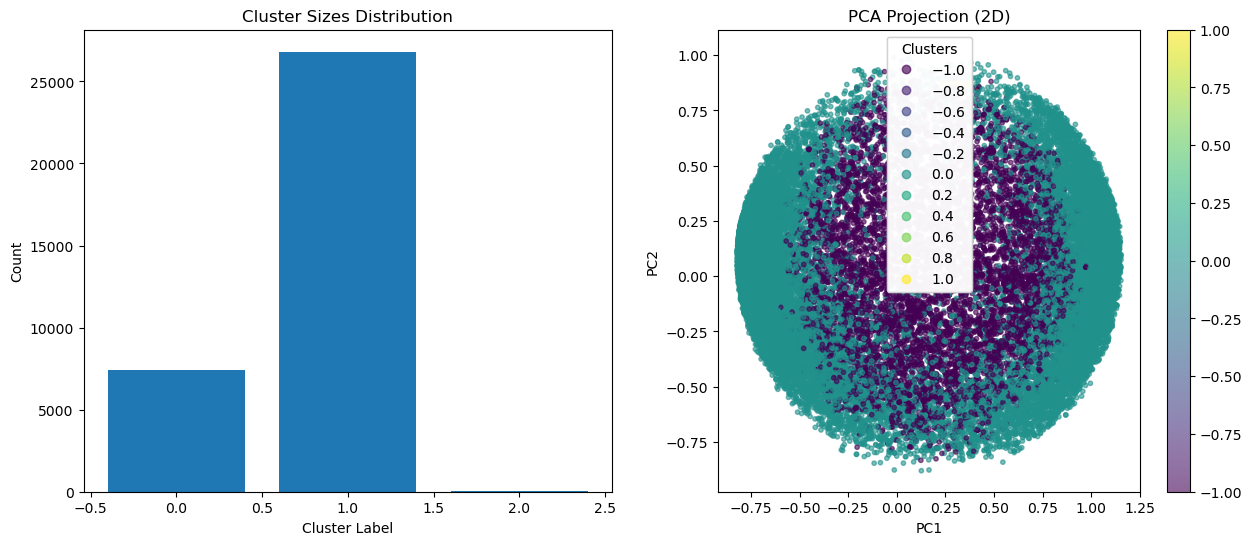

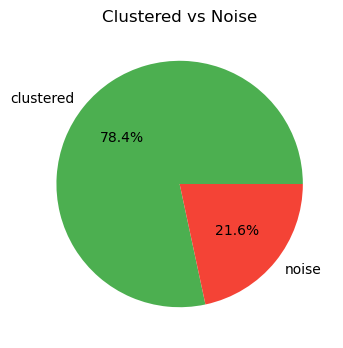

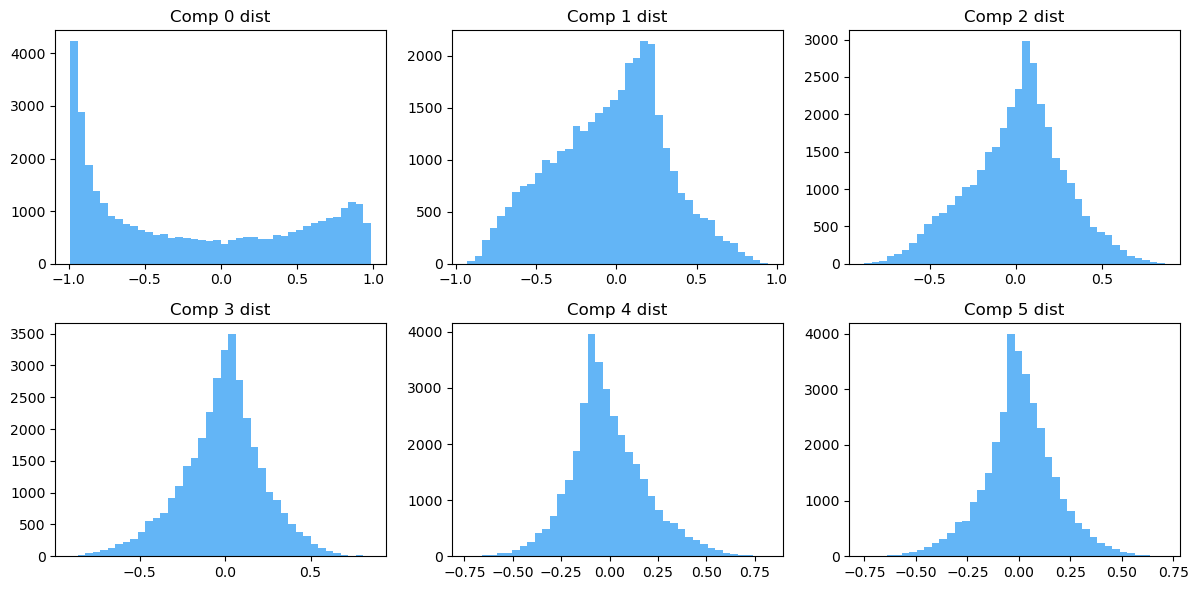

[Cell6] Cluster centroid (first 10 clusters, first 5 components):
  Cluster 0: size=26808 centroid_head=[-0.23423637449741364, -0.033463746309280396, 0.0218652430921793, -0.018754540011286736, -0.013035912066698074]
  Cluster 1: size=30 centroid_head=[0.2068490833044052, 0.7207899689674377, -0.21533431112766266, 0.21730725467205048, -0.07180566340684891]
[Cell6] Memory usage end: 426.00 MB
[Cell6] Done.


In [ ]:
# ==== Final clustering run & comprehensive analysis (pure internal metrics + visualization) ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, KMeans

final_eps = best_eps if 'best_eps' in globals() else DBSCAN_EPS
final_ms = best_ms if 'best_ms' in globals() else DBSCAN_MIN_SAMPLES
print(f"[Cell6] Final clustering with eps={final_eps:.4f} min_samples={final_ms} metric={CLUSTER_DISTANCE_METRIC}")

# Optional alternative algorithms (configure via variables if desired)
USE_KMEANS_COMPARE = False
KMEANS_CLUSTERS = 50  # Only used if USE_KMEANS_COMPARE=True

if BUCKET_BY and BUCKET_BY in df.columns:
    labels_final = np.full(len(df), -1, dtype=int)
    offset = 0
    for bname, subset in df.groupby(BUCKET_BY):
        idxs = subset.index.to_list()
        if len(idxs) < final_ms:
            continue
        X_subset = X_base[idxs]
        db = DBSCAN(eps=final_eps, min_samples=final_ms, metric=CLUSTER_DISTANCE_METRIC, n_jobs=-1)
        sub_labels = db.fit_predict(X_subset)
        unique_sub = [u for u in np.unique(sub_labels) if u != -1]
        mapping = {old: (offset + i) for i, old in enumerate(unique_sub)}
        for loc, lab in zip(idxs, sub_labels):
            if lab != -1:
                labels_final[loc] = mapping[lab]
        offset += len(unique_sub)
else:
    db = DBSCAN(eps=final_eps, min_samples=final_ms, metric=CLUSTER_DISTANCE_METRIC, n_jobs=-1)
    labels_final = db.fit_predict(X_base)

print("[Cell6] Unique labels (excluding noise):", [l for l in np.unique(labels_final) if l != -1])

if USE_KMEANS_COMPARE:
    print(f"[Cell6] Running KMeans comparison with n_clusters={KMEANS_CLUSTERS}")
    km = KMeans(n_clusters=KMEANS_CLUSTERS, random_state=RANDOM_STATE)
    km_labels = km.fit_predict(X_base)
    kmeans_metrics = comprehensive_evaluation(X_base, km_labels)
    print("[Cell6] KMeans internal metrics:", kmeans_metrics)
else:
    kmeans_metrics = None

if 'eval_pairs_available' in globals() and eval_pairs_available:
    final_metrics = evaluate_clusters_pairwise(eval_pairs, labels_final)
    print("[Cell6] Supervised pairwise metrics:", final_metrics)
else:
    final_metrics = None
    print("[Cell6] No eval_pairs; skipping supervised metrics.")

internal_final = internal_evaluation(X_base, labels_final)
comp_final = comprehensive_evaluation(X_base, labels_final)
print("[Cell6] Internal metrics:", internal_final)
print("[Cell6] Comprehensive metrics:", comp_final)

stats_df = cluster_stats(labels_final)
print("[Cell6] Cluster stats:")
print(stats_df)

col_name = 'cluster_label'
if col_name in df.columns:
    df.drop(columns=[col_name], inplace=True)
df[col_name] = labels_final
print(f"[Cell6] Added column '{col_name}' to dataframe.")

# Visualization
visualize_clustering(X_base, labels_final)

# Additional distribution plots (noise vs cluster ratio)
noise_count = int((labels_final == -1).sum())
clustered_count = len(labels_final) - noise_count
plt.figure(figsize=(4,4))
plt.pie([clustered_count, noise_count], labels=['clustered','noise'], autopct='%1.1f%%', colors=['#4caf50','#f44336'])
plt.title('Clustered vs Noise')
plt.show()

# Component distributions (first 6 components already normalized)
num_components_to_plot = min(6, X_base.shape[1])
plt.figure(figsize=(12,6))
for i in range(num_components_to_plot):
    plt.subplot(2,3,i+1)
    plt.hist(X_base[:, i], bins=40, color='#2196f3', alpha=0.7)
    plt.title(f'Comp {i} dist')
plt.tight_layout()
plt.show()

# Snapshot of cluster centroids (first 5 components)
from collections import defaultdict
cluster_details = defaultdict(dict)
for lab in sorted([l for l in np.unique(labels_final) if l != -1]):
    idxs = np.where(labels_final == lab)[0]
    if len(idxs) == 0:
        continue
    sub = X_base[idxs]
    cluster_details[lab] = dict(size=len(idxs), centroid=sub.mean(axis=0)[:5].tolist())
print("[Cell6] Cluster centroid (first 10 clusters, first 5 components):")
for lab, info in list(cluster_details.items())[:10]:
    print(f"  Cluster {lab}: size={info['size']} centroid_head={info['centroid']}")

print(f"[Cell6] Memory usage end: {memory_usage_mb():.2f} MB")
print("[Cell6] Done.")

In [ ]:
# ==== Post-hoc external label validation (optional, does not affect clustering) ====
# This cell computes Adjusted Rand Index (ARI) only AFTER clustering,
# to quantify alignment between discovered clusters and any existing label_group.
# It does NOT feed label_group into feature construction or parameter search.

from sklearn.metrics import adjusted_rand_score

def post_hoc_label_validation(df_items: pd.DataFrame,
                              cluster_col: str = 'cluster_label',
                              label_col: str = 'label_group') -> None:
    """Compute ARI between cluster assignments and provided labels (if available).
    Conditions:
      - Both columns must exist.
      - At least 3 clustered (non-noise) items.
      - More than 1 unique ground-truth label among clustered points.
    This is purely diagnostic and preserves unsupervised integrity.
    """
    if cluster_col not in df_items.columns or label_col not in df_items.columns:
        print(f"[validation] Columns missing: need '{cluster_col}' and '{label_col}'. Skipping.")
        return
    mask = (df_items[cluster_col] != -1)
    if mask.sum() < 3:
        print("[validation] Not enough clustered points for ARI (need >=3).")
        return
    gt = df_items[label_col][mask]
    cl = df_items[cluster_col][mask]
    if gt.nunique() < 2:
        print("[validation] Ground-truth labels not diverse (need >=2 unique). Skipping ARI.")
        return
    ari = adjusted_rand_score(gt, cl)
    print(f"[validation] Post-hoc Adjusted Rand Index (ARI): {ari:.6f}")

# Run validation (safe if label_group absent)
post_hoc_label_validation(df)
